In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lib import DihedralAdherencePDB
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'ml_data'

pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]

In [3]:
da = DihedralAdherencePDB(
    pdb_codes[40], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
    kdews=[0, 0, 0, 1]
)

Results already exist
Structure exists: 'pdb/pdb3kff.ent' 
UniProt ID: P11590


In [5]:
da.load_results()

In [8]:
da.xray_phi_psi.to_csv(da.outdir / 'test.csv')

In [ ]:
# da = DihedralAdherencePDB(
#     pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
#     weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cuda'
# )
for pdb_code in pdb_codes[50:150]:
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
        kdews=[0, 0, 0, 1]
    )
    da.load_results()
    da.compute_das()

In [17]:
results

[  Model  GDT_TS     RMS_CA  DA
 0  7LUL     0.0  49.216044 NaN,
   Model    GDT_TS    RMS_CA  DA
 0  3R7U  0.844858  1.704878 NaN,
   Model    GDT_TS    RMS_CA  DA
 0  5TPI  0.710976  4.947146 NaN,
   Model    GDT_TS    RMS_CA  DA
 0  6A0J  0.998864  0.194671 NaN]

In [38]:
results = []
for pdb_code in pdb_codes[:150]:
    if not Path(f'{PROJECT_DIR}/{pdb_code}_win4-5-6-7/xray_phi_psi_da.csv').exists():
        continue
    da = DihedralAdherencePDB(
        pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
        kdews=[0, 0, 0, 1]
    )
    da.load_results_da()
    results.append(da.results)
results = pd.concat(results, axis=0).reset_index(drop=True)

Results already exist
Structure exists: 'pdb/pdb2rj7.ent' 
UniProt ID: P16442
Results already exist
Structure exists: 'pdb/pdb1f81.ent' 
UniProt ID: P45481
Results already exist
Structure exists: 'pdb/pdb1ey7.ent' 
UniProt ID: P00644
Results already exist
Structure exists: 'pdb/pdb4aqi.ent' 
UniProt ID: Q86SG5
Results already exist
Structure exists: 'pdb/pdb4mkh.ent' 
UniProt ID: P16304
Results already exist
Structure exists: 'pdb/pdb7eik.ent' 
UniProt ID: O60885
Results already exist
Structure exists: 'pdb/pdb5nq8.ent' 
UniProt ID: Q96TR6
Results already exist
Structure exists: 'pdb/pdb4nv6.ent' 
UniProt ID: Q2JJF6
Results already exist
Structure exists: 'pdb/pdb2nu6.ent' 
UniProt ID: P0AGE9
Results already exist
Structure exists: 'pdb/pdb2xne.ent' 
UniProt ID: O14965
Results already exist
Structure exists: 'pdb/pdb6lvq.ent' 
UniProt ID: Q9NRW4
Results already exist
Structure exists: 'pdb/pdb5p6t.ent' 
UniProt ID: P11838
Results already exist
Structure exists: 'pdb/pdb5auu.ent' 
UniPr

In [45]:
total = 0
for pdb_code in pdb_codes:
    fn = f'{PROJECT_DIR}/{pdb_code}_win4-5-6-7/xray_phi_psi_da.csv'
    if Path(fn).exists():
        total += 1
total

47

In [53]:
da.queries[3].get_center_idx_pos()

3

0.03741358017777405

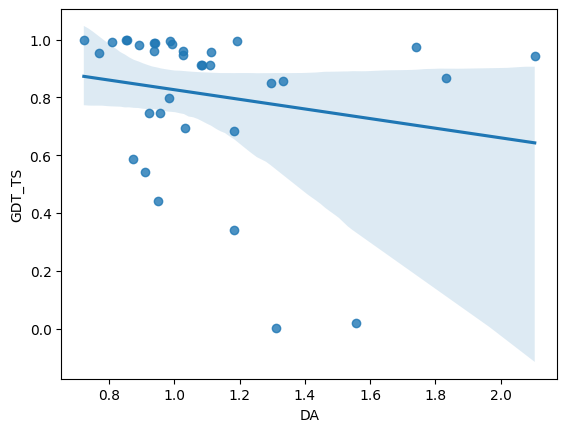

In [43]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
reg = linregress(results.dropna()['DA'], results.dropna()['GDT_TS'])
sns.regplot(x='DA', y='GDT_TS', data=results.reset_index(drop=True))
reg.rvalue**2

In [4]:
da = DihedralAdherencePDB(
    pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='kde',
    kdews=[0, 0, 0, 1]
)
da.load_results_da()

Results already exist
Structure exists: 'pdb/pdb2rj7.ent' 
UniProt ID: P16442


In [146]:
from lib import DihedralAdherence
da = DihedralAdherence(
    'T1024', [4,5,6,7], PDBMINE_URL, 'casp_da', mode='kde',
    kdews=[0, 0, 0, 1]
)

Initializing T1024 ...
casp_da/T1024_win4-5-6-7
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
UniProt ID: Q48658


In [147]:
from Bio.PDB import Superimposer, PDBParser
import warnings
from Bio.Align import PairwiseAligner
from lib.constants import AMINO_ACID_CODES
import numpy as np

def get_aligned_atoms(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True):
    # Compute RMSD between two structures
    pdb_parser = PDBParser()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        structureA = pdb_parser.get_structure('', fnA)
        structureB = pdb_parser.get_structure('', fnB)
    
    chainA = next(iter(structureA[0].get_chains()))
    chainB = next(iter(structureB[0].get_chains()))

    startA = startA or 0
    endA = endA or len(chainA)
    startB = startB or 0
    endB = endB or len(chainB)

    residuesA = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainA.get_residues()])[startA:endA]
    residuesB = ''.join([AMINO_ACID_CODES.get(r.resname, 'X') for r in chainB.get_residues()])[startB:endB]
    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residuesA, residuesB)
    if print_alignment:
        print(alignments[0])

    atomsA = []
    atomsB = []
    residuesA = list(chainA.get_residues())[startA:endA]
    residuesB = list(chainB.get_residues())[startB:endB]
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        for j, (residueA, residueB) in enumerate(zip(residuesA[t1:t2], residuesB[q1:q2])):
            if residueA.resname != residueB.resname:
                print(f'WARNING: Residues {residueA.resname} and {residueB.resname} don\'t match at position: {j}')
            try:
                atomA = residueA['CA']
                atomB = residueB['CA']
            except KeyError:
                print(f'WARNING: Atom "CA" missing at position: {i}')
                continue
            if atomB is None or atomA is None:
                print(f'WARNING: Atom "CA" missing at position: {i}')
                continue
            atomsA.append(atomA)
            atomsB.append(atomB)
    return atomsA, atomsB

def compute_rmsd(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True, return_n=False):
    atomsA, atomsB = get_aligned_atoms(fnA, fnB, startA, endA, startB, endB, print_alignment)

    sup = Superimposer()
    sup.set_atoms(atomsA, atomsB)
    sup.apply(atomsB)
    if return_n:
        atomsA = np.array([a.coord for a in atomsA])
        atomsB = np.array([a.coord for a in atomsB])
        dist = np.sum((atomsA - atomsB)**2)
        return sup.rms, len(atomsA), dist
    return sup.rms

def compute_gdt(fnA, fnB, startA=None, endA=None, startB=None, endB=None, print_alignment=True, return_n=False, thresholds=[1,2,4,8]):
    atomsA, atomsB = get_aligned_atoms(fnA, fnB, startA, endA, startB, endB, print_alignment)

    sup = Superimposer()
    sup.set_atoms(atomsA, atomsB)
    sup.apply(atomsB)
    atomsA = np.array([a.coord for a in atomsA])
    atomsB = np.array([a.coord for a in atomsB])
    n = atomsA.shape[0]

    dist = np.linalg.norm(atomsA - atomsB, axis=1)
    gdt = []
    for t in thresholds:
        gdt.append((dist <= t).sum() / n)
    return np.mean(gdt)

af_fn = da.predictions_dir / 'T1030TS427_4'
print(compute_rmsd(da.xray_fn, af_fn, print_alignment=False))
compute_gdt(da.xray_fn, af_fn, print_alignment=False)

FileNotFoundError: [Errno 2] No such file or directory: 'casp-predictions/T1024/T1030TS427_4'

In [156]:
gdts = []
rmsds = []
for i,row in da.results.iterrows():
    fn = row['Model']
    gdt = compute_gdt(da.xray_fn, da.predictions_dir / fn, print_alignment=False)
    rmsd = compute_rmsd(da.xray_fn, da.predictions_dir / fn, print_alignment=False)
    gdts.append(gdt)
    rmsds.append(rmsd)
da.results['GDT2'] = gdts
da.results['RMSD2'] = rmsds
da.results['GDT2'] = da.results['GDT2'] * 100

<Axes: >

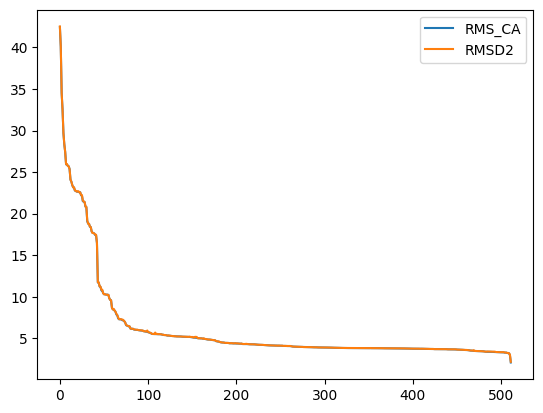

In [158]:
# da.results[['GDT_TS', 'GDT2']].plot()
da.results[['RMS_CA', 'RMSD2']].sort_values('RMS_CA', ascending=False).reset_index(drop=True).plot()

<Axes: >

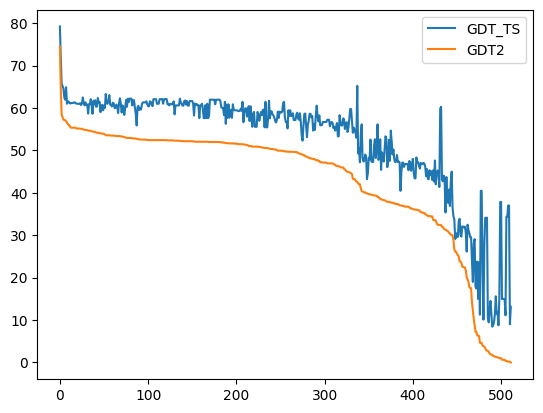

In [154]:
da.results[['GDT_TS', 'GDT2']].sort_values('GDT2', ascending=False).reset_index(drop=True).plot()